In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from matplotlib import style
from matplotlib.ticker import StrMethodFormatter
style.use("seaborn-v0_8-pastel")

In [2]:
# Configurações do Pandas
pd.options.display.max_columns = 26

In [3]:
# Arrays e dicionários úteis

columns = ["NU_ANO","TP_NACIONALIDADE","TP_SEXO","TP_FAIXA_ETARIA","TP_COR_RACA","TP_ESTADO_CIVIL",
           "TP_ST_CONCLUSAO","TP_ESCOLA","IN_TREINEIRO","NO_MUNICIPIO_ESC","SG_UF_PROVA","TP_PRESENCA_CN",
           "TP_PRESENCA_CH","TP_PRESENCA_LC","TP_PRESENCA_MT","NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_LC",
           "NU_NOTA_MT","TP_STATUS_REDACAO","NU_NOTA_COMP1","NU_NOTA_COMP2","NU_NOTA_COMP3","NU_NOTA_COMP4",
           "NU_NOTA_COMP5","NU_NOTA_REDACAO"]

renamed_columns = ["Ano","Nacionalidade","Sexo","Idade","Cor","Estado_civil","Situacao_EM","Tipo_Escola",
                   "Treineiro","Municipio","Estado","Presenca_CN","Presenca_CH","Presenca_LC","Presenca_MT",
                   "Ciencias_Natureza","Ciencias_Humanas","Linguagens_Codigos","Matematica","Status_Redacao",
                   "Ortografia","Desenvolvimento","Informacoes","Organizacao","Proposta","Redacao"]

# Conseguindo a relação das categorias das colunas
faixa_etaria = {
    1: "Menor de 17 anos",
    2: "17 anos",
    3: "18 anos",
    4: "19 anos",
    5: "20 anos",
    6: "21 anos",
    7: "22 anos",
    8: "23 anos",
    9: "24 anos",
    10: "25 anos",
    11: "Entre 26 e 30 anos",
    12: "Entre 31 e 35 anos",
    13: "Entre 36 e 40 anos",
    14: "Entre 41 e 45 anos",
    15: "Entre 46 e 50 anos",
    16: "Entre 51 e 55 anos",
    17: "Entre 56 e 60 anos",
    18: "Entre 61 e 65 anos",
    19: "Entre 66 e 70 anos",
    20: "Maior de 70 anos"
}

estado_civil = {
    0: "Não informado",
    1: "Solteiro(a)",
    2: "Casado(a)/Mora com companheiro(a)",
    3: "Divorciado(a)/Desquitado(a)/Separado(a)",
    4: "Viúvo(a)"
}

etnia = {
    0: "Não declarado",
    1: "Branca",
    2: "Preta",
    3: "Parda",
    4: "Amarela",
    5: "Indígena",
    6: "Não dispõe da informação"
}

nacionalidade = {
    0: "Não informado",
    1: "Brasileiro(a)",
    2: "Brasileiro(a) Naturalizado(a)",
    3: "Estrangeiro(a)",
    4: "Brasileiro(a) Nato(a), nascido(a) no exterior"
}

situacao_ensino_medio = {
    1: "Já concluí o Ensino Médio",
    2: "Estou cursando e concluirei o Ensino Médio em 2022",
    3: "Estou cursando e concluirei o Ensino Médio após 2022",
    4: "Não concluí e não estou cursando o Ensino Médio"
}

tipo_instituicao = {
    1: "Não Respondeu",
    2: "Pública",
    3: "Privada"
}

treineiro = {
    1: "Sim",
    0: "Não"
}

situacao_redacao = {
    1: "Sem problemas",
    2: "Anulada",
    3: "Cópia Texto Motivador",
    4: "Em Branco",
    6: "Fuga ao tema",
    7: "Não atendimento ao tipo textual",
    8: "Texto insuficiente",
    9: "Parte desconectada"
}

In [4]:
# Pegar o arquivo .csv dos microdados de dentro de todos os zips
zip_data = {
    "Zip Files":[],
    "Folder Data":  os.listdir("information")
}

for zippedArch in zip_data["Folder Data"]:
    with zipfile.ZipFile(f"information\{zippedArch}") as zippedData:
        for file in zippedData.namelist():
            if "microdados" in file.lower() and file.endswith(".csv"):
                zip_data["Zip Files"].append(file)

In [5]:
# Lambda pra ordenar os arquivos do mais antigo para o mais novo 2015 - 2022
zip_data["Zip Files"].sort(key = lambda x: x[22:-4])
zip_data["Folder Data"].sort(key = lambda x: x[16:-4])

In [6]:
enem_collection = []

# Criando o megadataframe filtrado
for i in range(len(zip_data["Zip Files"])):
    with zipfile.ZipFile(f"information\{zip_data['Folder Data'][i]}") as microdata:
        with microdata.open(zip_data["Zip Files"][i]) as csv:
            
            data = pd.read_csv(csv,encoding="ISO-8859-1",sep=";",usecols=columns)
            # Renomeando as colunas
            data.columns = renamed_columns
            # Removendo as linhas onde não temos notas
            data.dropna(subset=["Ciencias_Natureza",'Ciencias_Humanas',"Ciencias_Humanas","Matematica","Redacao"],inplace=True)
            data.reset_index(inplace=True,drop=True)
            # Adicionando no array pra criar o Dataframe completo posteriormente
            enem_collection.append(data)


In [7]:
enem = pd.concat(enem_collection)

In [24]:
# Calculando a Nota Total de cada pessoa
enem['Nota Total'] = enem[['Ciencias_Natureza','Ciencias_Humanas','Matematica','Linguagens_Codigos','Redacao']].sum(axis=1)/5

In [25]:
enem.groupby("Ano")[["Ciencias_Humanas","Linguagens_Codigos","Matematica","Redacao"]].mean()

,Ciencias_Humanas,Linguagens_Codigos,Matematica,Redacao
Ano,,,,
2015,559.268777,505.578629,468.088781,534.851685
2016,535.326088,521.042458,490.233025,530.312837
2017,521.452181,512.150346,518.831999,529.386232
2018,570.811613,528.516401,535.490047,516.057887
2019,509.889825,522.396624,523.185038,579.766602
2020,514.286982,526.019202,520.727299,581.335282
2021,523.182030,504.875292,535.197098,622.546196
2022,529.968661,519.876832,542.611168,628.950040


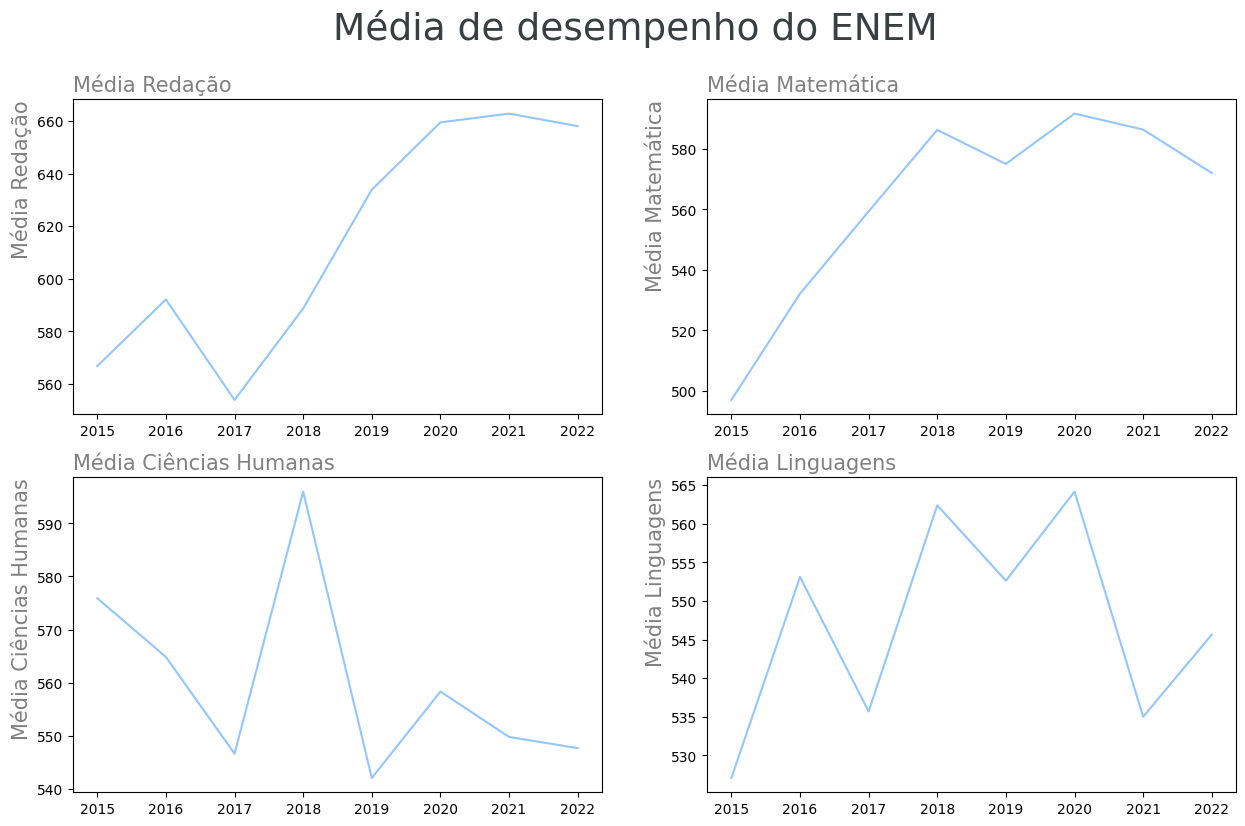

In [26]:
fig,axs = plt.subplots(2,2,figsize=(15,9))

axs[0,0].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Redacao"].mean())
axs[0,0].set_title("Média Redação",fontsize=15,color='gray',loc='left')
axs[0,0].set_ylabel("Média Redação",fontsize=15,color='gray',loc='top')

axs[1,0].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Ciencias_Humanas"].mean())
axs[1,0].set_title("Média Ciências Humanas",fontsize=15,color='gray',loc='left')
axs[1,0].set_ylabel("Média Ciências Humanas",fontsize=15,color='gray',loc='top')

axs[0,1].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Matematica"].mean())
axs[0,1].set_title("Média Matemática",fontsize=15,color='gray',loc='left')
axs[0,1].set_ylabel("Média Matemática",fontsize=15,color='gray',loc='top')

axs[1,1].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Linguagens_Codigos"].mean())
axs[1,1].set_title("Média Linguagens",fontsize=15,color='gray',loc='left')
axs[1,1].set_ylabel("Média Linguagens",fontsize=15,color='gray',loc='top')


fig.suptitle('Média de desempenho do ENEM',fontsize=27,color="#393E41")

plt.savefig('foo.png', bbox_inches='tight')

## Qual o Ano que tivemos mais Treineiros?

In [75]:
# Buscando o percentual de Treineiros em cada ano
trein_year = pd.DataFrame(enem.groupby("Ano")['Treineiro'].value_counts(normalize=True)).reset_index()

In [76]:
# Pivotando a e ajustando a tabela pra ficar mais fácil de usar um gráfico horizontal
trein_year = trein_year.pivot_table('proportion', ['Ano'], 'Treineiro').reset_index()
trein_year.columns = ['Ano',"Não Treineiros","Treineiros"]
trein_year = trein_year[['Ano',"Treineiros","Não Treineiros"]].sort_values("Treineiros",ascending=False)
# Transformando os resultados em Porcentagem pra poder utilizar no gráfico a seguir
trein_year = trein_year.map(lambda x: x*100 if type(x) == float else x)

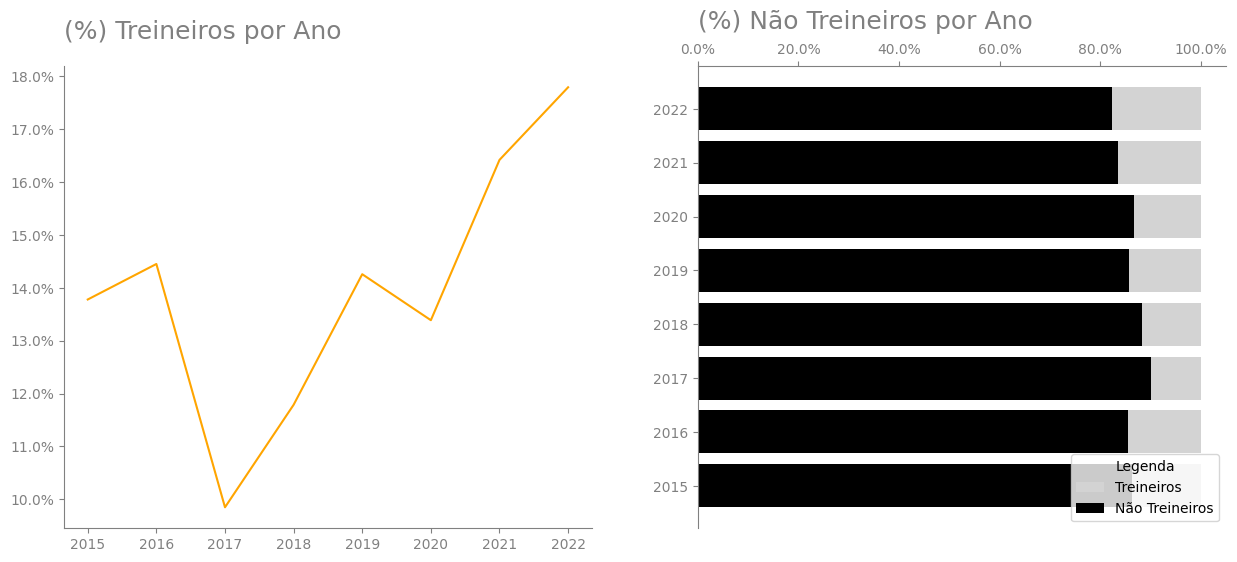

In [154]:
# Criando os gráficos Line Chart e Horizontal Bar
fig, axs = plt.subplots(1,2,figsize=(15,6))

# Criando o Line Chart pra visualizar o crescimento de Treineiros ao longo dos anos
axs[0].plot(trein_year['Ano'],trein_year['Treineiros'],color='orange')
axs[0].yaxis.set_major_formatter(StrMethodFormatter('{x}%'))
axs[0].set_title("(%) Treineiros por Ano",loc='left',color='gray',pad=20,size=18)
# Removendo as bordas do gráfico
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_color("gray")
axs[0].spines['left'].set_color("gray")
axs[0].tick_params(axis='x', colors='gray')
axs[0].tick_params(axis='y', colors='gray')

# Criando o Horizontal Bar
b1 = plt.barh(trein_year['Ano'],trein_year["Não Treineiros"],color='black')
b2 = plt.barh(trein_year['Ano'],trein_year["Treineiros"],color='lightgray',left=trein_year["Não Treineiros"])

plt.title("(%) Não Treineiros por Ano",loc='left',color='gray',pad=10,size=18)
plt.legend([b2, b1], ["Treineiros", "Não Treineiros"], title="Legenda", loc="lower right")

# Configurando os Axis do gráfico pra obter uma visualização mais Limpa e Uniforme dos dados
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x}%'))
plt.gca().xaxis.set_ticks_position('top')
plt.tick_params(axis='x', colors='gray')
plt.tick_params(axis='y', colors='gray')
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_color("gray")
plt.gca().spines['left'].set_color("gray")

## Quais os Estados com as melhores notas?

,Ano,Nacionalidade,Sexo,Idade,Cor,Estado_civil,Situacao_EM,Tipo_Escola,Treineiro,Municipio,Estado,Presenca_CN,Presenca_CH,...,Presenca_MT,Ciencias_Natureza,Ciencias_Humanas,Linguagens_Codigos,Matematica,Status_Redacao,Ortografia,Desenvolvimento,Informacoes,Organizacao,Proposta,Redacao,Nota Total
0,2015,14,M,1.0,1,1,1,1,0,NaN,RS,1.0,1.0,...,1.0,657.4,705.3,591.1,732.3,1.0,160.0,160.0,120.0,160.0,160.0,760.0,689.22
1,2015,7,M,1.0,2,1,4,1,0,NaN,PE,1.0,1.0,...,1.0,528.5,531.1,511.3,566.5,1.0,120.0,120.0,120.0,140.0,140.0,640.0,555.48
2,2015,3,M,0.0,3,1,1,1,0,NaN,MG,1.0,1.0,...,1.0,679.9,730.6,621.2,732.4,1.0,160.0,160.0,160.0,180.0,140.0,800.0,712.82
3,2015,4,M,0.0,1,1,1,1,0,NaN,SC,1.0,1.0,...,1.0,598.7,658.0,579.0,576.4,1.0,120.0,80.0,100.0,120.0,60.0,480.0,578.42
4,2015,2,F,0.0,1,1,2,2,0,Guarulhos,SP,1.0,1.0,...,1.0,652.1,671.9,609.3,685.5,1.0,180.0,160.0,160.0,160.0,160.0,820.0,687.76
